## K-Armed Bandits example
### Definitions
$q_*(a)=E[R_t|A_t=a]$: Value of an arbitrary action $a$ is the expected reward given that $a$ is selected <br/>
$a:$ Set of all possible actions <br/>
$Q_i(a):$ Action-value estimates at step i for any action <br/>
$A_i:$ Action taken at step i <br/>
$R_i:$ Reward obtained for action A_i <br/>

### Sample average
$Q_t(a) = \frac{\text{sum of rewards when a taken prior to t}}{\text{sum of times a taken prior to t}} = \frac{\sum_{i=1}^{t-1}R_i \cdot \mathrm{I}_{A_i=a}}{\sum_{i=1}^{t-1}\mathrm{I}_{A_i=a}}$ 

Where $\mathrm{I} = 1$ if $A_i = a$ and $0$ if not.

### Greedy policy
$A_t = argmax_a Q_t(a)\rightarrow$Always exploits, no exploration.
#### $\epsilon$-Greedy
Choose action $A_t$ (greedily) with probability $1-\epsilon$, and choose randomly from all possible actions with probability $\epsilon$. This allows to exploit most of the time, while having room for exploration.

An advantage of this method is that $Q_{t\rightarrow \infty}(a) = q_*(a)$, and the probability of choosing the optimal policy is $1-\epsilon$

## Calculating Q_t(a) with sample average

In [2]:
import numpy as np
import time
import random
np.seterr(divide='ignore', invalid='ignore')

import tensorflow_probability as tfp
import tensorflow as tf
tf.enable_eager_execution()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
actions = np.array([1,2,3,4], dtype = np.float32) # possible actions ("a")
action_seq = np.array([1,2,2,2,3], np.float32) # Actions taken (A_i)
rewards = np.array([1,1,2,2,0], np.float32) #Rewards gained (R_i)
Q = np.zeros(actions.shape[0]) #Estimated values

def sample_avg(actions, action_seq, rewards):
    steps = range(1, len(action_seq)+1)
    q = np.zeros((len(steps)+1, len(actions)))
    for t in steps:
        num = np.array([rewards[:t][action_seq[0:t]==i] for i in actions])
        num = np.array([np.sum(num[i]) for i in range(len(num))])
        den = np.sum(np.array([action_seq[0:t]==i for i in actions]), axis = 1)
        q[t,:]=np.where(den == 0, den, num/den)
    return q
q = sample_avg(actions, action_seq, rewards)
print(q, action_seq)

[[0.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         1.         0.         0.        ]
 [1.         1.5        0.         0.        ]
 [1.         1.66666667 0.         0.        ]
 [1.         1.66666667 0.         0.        ]] [1. 2. 2. 2. 3.]


Step 1: Random, all actions have same Q.<br/>
Step 2: $\epsilon$, didn't choose highest Q action.<br/>
Step 3: Random, options 1 and 2 have the same rewards.<br/>
Step 4: Greedy or $\epsilon$, option with highest Q is chosen, could be for greed or randomness.  
Step 5: $\epsilon$, didn't choose highest Q action.

[ 0.41602397 -0.8454377  -0.60079336 -0.6086048   0.49276072 -1.480535
 -1.69938    -0.02078592 -0.9047766   0.01771036] [ 0.41602397 -0.8454377  -0.60079336 -0.6086048   0.49276072 -1.480535
 -1.69938    -0.02078592 -0.9047766   0.01771036] [ 0.41602397 -0.8454377  -0.60079336 -0.6086048   0.49276072 -1.480535
 -1.69938    -0.02078592 -0.9047766   0.01771036]
Run 1: 2.10 seconds
Elapsed time: 400.72 seconds
Run 1: 1.97 seconds
Elapsed time: 394.31 seconds
Run 1: 1.91 seconds
Elapsed time: 391.39 seconds


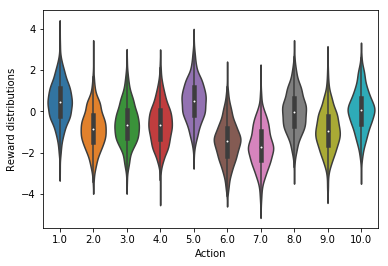

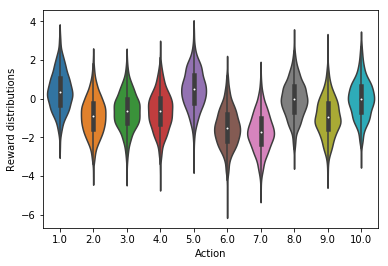

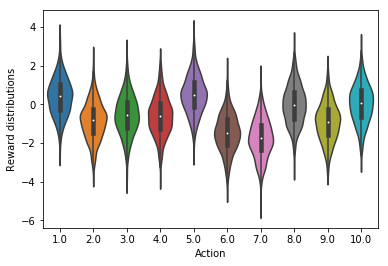

In [53]:
class EpsilonGreedy():
    def __init__(self, n_actions = 10, epsilon = 0, steps = 3000, 
                 iterations = 200, mean = 0, std = 1, q_real = None):
        #Initialize parameters
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.steps = steps
        self.iterations = iterations
        self.stats = {'mean': mean, 'std': std}

        #Generate true expected values q*
        q_gen =  tfp.distributions.Normal(loc=0, scale=1)
        if q_real is None:
            self.q_real = q_gen.sample([self.n_actions]).numpy()
        else:
            self.q_real = q_real
        
        #Normal with mean = q*, std = 1
        self.q_real_dist = []
        for i in self.q_real:
            self.q_real_dist.append(tfp.distributions.Normal(loc=i, scale=self.stats['std']))
        
        
        self.A_seq = np.empty((self.steps, self.iterations))
        self.R_seq = np.empty((self.steps, self.iterations))
        #self.N_seq = np.empty((self.steps, self.n_actions))
        #self.Q_seq = np.empty((self.steps, self.n_actions))
    
    def plot_true_values(self, samples):
        q_real_dist = tfp.distributions.Normal(loc=self.q_real, scale = self.stats['std'])
        R = q_real_dist.sample(samples).numpy().T.reshape(-1)
        s = np.repeat([i for i in range(1, self.n_actions+1)], samples)
        df = pd.DataFrame(data = [s, R]).T
        df.columns = ['Action','Reward distributions']
        plt.figure()
        sns.violinplot(x = 'Action', y = 'Reward distributions', data = df)
        
    def sample_average(self):
        start = time.time()
        iter_start = time.time()
        for i in range(self.iterations):
            Q = [0]*self.n_actions
            N = Q.copy()
            for t in range(self.steps):
                if 1 - self.epsilon > random.random(): #exploitation
                    Q_argmax = [i for i, j in enumerate(Q) if j == max(Q)] #break ties randomly  
                    if len(Q_argmax) == 1:
                        A = Q_argmax[0]
                    else: #break ties randomly
                        A = random.choice(Q_argmax)
                else: #exploration
                    A = np.random.randint(self.n_actions)

                R = self.q_real_dist[A].sample().numpy()
                N[A] = N[A] + 1
                self.A_seq[t, i] = A
                self.R_seq[t, i] = R
                #self.N_seq[t] = N
                #self.Q_seq[t] = Q

                Q[A] = Q[A] + 1/N[A]*(R-Q[A])
                
            if i%200 == 0:
                print("Run {}: {:.2f} seconds".format(i+1, time.time() - iter_start))
                iter_start = time.time()
        print("Elapsed time: {:.2f} seconds".format(time.time() - start))

test_1 = EpsilonGreedy(epsilon = 0)
test_2 = EpsilonGreedy(epsilon = .01, q_real = test_1.q_real) #real values are the same for all tests
test_3 = EpsilonGreedy(epsilon = .1, q_real = test_1.q_real)

test_1.plot_true_values(1000)
test_2.plot_true_values(1000)
test_3.plot_true_values(1000)

test_1.sample_average()
test_2.sample_average()
test_3.sample_average()

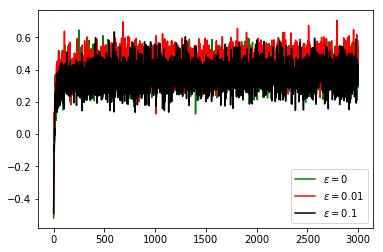

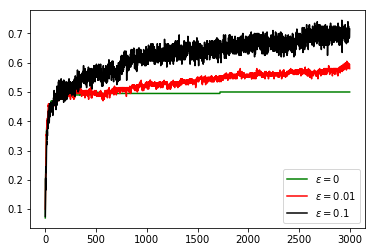

In [54]:
rwd_1 = np.mean(test_1.R_seq, axis = 1)
rwd_2 = np.mean(test_2.R_seq, axis = 1)
rwd_3 = np.mean(test_3.R_seq, axis = 1)

plt.figure()
plt.plot(rwd_1, 'g', label = r'$\epsilon = 0$')
plt.plot(rwd_2, 'r', label = r'$\epsilon = 0.01$')
plt.plot(rwd_3, 'k', label = r'$\epsilon = 0.1$')
plt.legend()

err_1 = np.mean(test_1.A_seq == np.argmax(test_1.q_real), axis = 1)
err_2 = np.mean(test_2.A_seq == np.argmax(test_2.q_real), axis = 1)
err_3 = np.mean(test_3.A_seq == np.argmax(test_3.q_real), axis = 1)

plt.figure()
plt.plot(err_1, 'g', label = r'$\epsilon = 0$')
plt.plot(err_2, 'r', label = r'$\epsilon = 0.01$')
plt.plot(err_3, 'k', label = r'$\epsilon = 0.1$')
plt.legend()